## Context
This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

## Content

**Attribute Information: **
- age = age in years
- sex = (1 = male; 0 = female)
- cp = chest pain type
- trestbps = resting blood pressure (in mm Hg on admission to the hospital)
- chol = serum cholestoral in mg/dl
- fbs = (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg = resting electrocardiographic results
- thalach = maximum heart rate achieved
- exang = exercise induced angina (1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- slope = the slope of the peak exercise ST segment
- ca = number of major vessels (0-3) colored by flourosopy
- thal = 3 = normal; 6 = fixed defect; 7 = reversable defect
- target = 1 or 0 (1 being heart disease, 0 being no heart disease

## Get the Data


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


In [2]:
Data = pd.read_csv('../input/heart.csv')

In [3]:
!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf
tf.random.set_seed(123)

In [4]:
Data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Split up the data to training set and test set

In [5]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(Data,test_size=0.2, random_state=42)

In [6]:
train_X = train_set.drop('target',axis=1)
train_y = train_set['target']

test_X = test_set.drop('target',axis=1)
test_y = test_set['target']

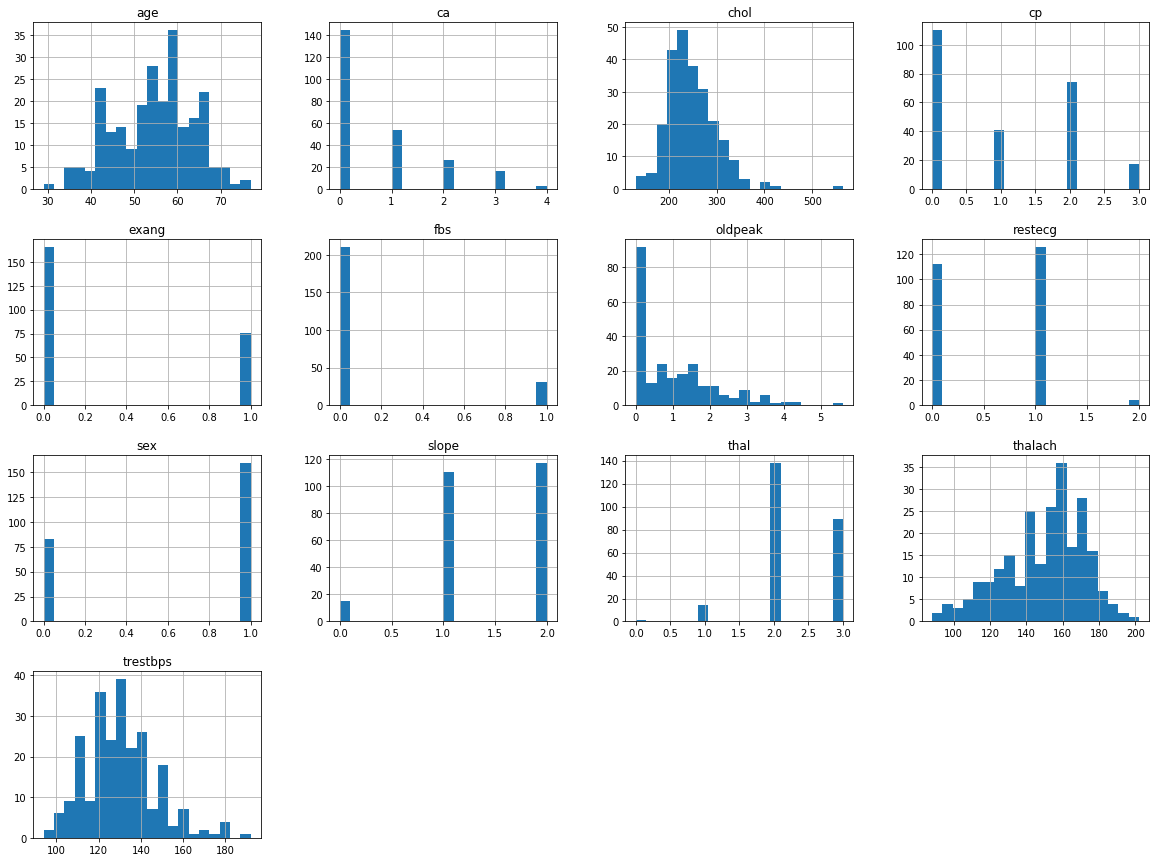

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
train_X.hist(bins=20, figsize=(20,15))
plt.show()

From the graph below we can see most of the people in this dataset have an age between 50 and 60

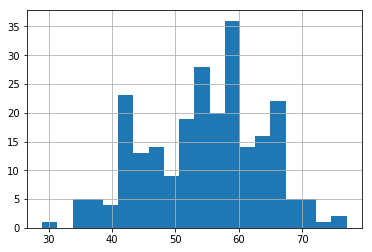

In [8]:
train_X.age.hist(bins=20);

Most of the data is male

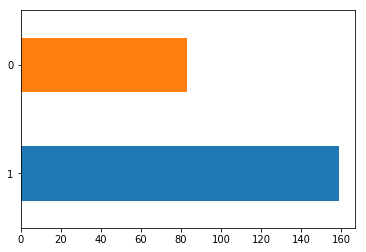

In [9]:
train_X.sex.value_counts().plot(kind='barh');

From the code below it seems that women are less susseptible to heart disease

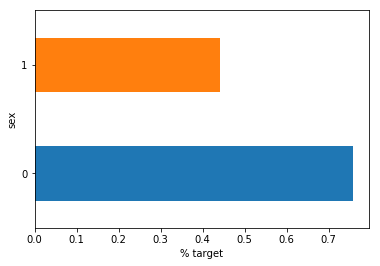

In [10]:
pd.concat([train_X, train_y], axis=1).groupby('sex').target.mean().plot(kind='barh').set_xlabel('% target');

## Prepare the Data

- to deal with categorical data i will use one hot vector

In [11]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'cp', 'fbs', 'restecg', 'exang', 
                       'slope', 'ca','thal']
NUMERIC_COLUMNS = ['age', 'trestbps','chol','thalach','oldpeak']
  
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = train_X[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

In [12]:
#tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

In [13]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(train_y)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(train_X, train_y)
eval_input_fn = make_input_fn(test_X, test_y, shuffle=False, n_epochs=1)

## Train the model
1. using logistic regretion 
2. using Boosted Trees

In [14]:
#Logistic
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
#clear_output()
print(pd.Series(result))

W0319 02:23:46.438974 139783169553792 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpqg66z3dm
W0319 02:23:46.464662 139783169553792 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0319 02:23:46.564595 139783169553792 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0319 02:23:46.576449 139783169553792 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_col

accuracy                  0.868852
accuracy_baseline         0.524590
auc                       0.920259
auc_precision_recall      0.921154
average_loss              0.521361
label/mean                0.524590
loss                      0.521361
precision                 0.833333
prediction/mean           0.595433
recall                    0.937500
global_step             100.000000
dtype: float64


In [15]:
# Boosted Trees 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
print(pd.Series(result))

W0319 02:23:52.562139 139783169553792 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpyqhv72qe
W0319 02:23:52.615570 139783169553792 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column.py:2121: NumericColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0319 02:23:52.619587 139783169553792 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column.py:2121: IndicatorColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0319 02:23:52.620301 1

accuracy                  0.852459
accuracy_baseline         0.524590
auc                       0.916487
auc_precision_recall      0.929667
average_loss              0.495074
label/mean                0.524590
loss                      0.495074
precision                 0.896552
prediction/mean           0.447184
recall                    0.812500
global_step             100.000000
dtype: float64


- the logistic model did better, so if you want the best predictions it might make more sense to use the logistic model. 
- for determing feature importance i will use the Boosted Trees model 

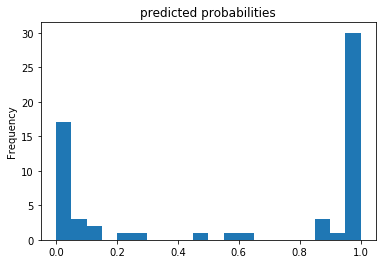

In [16]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

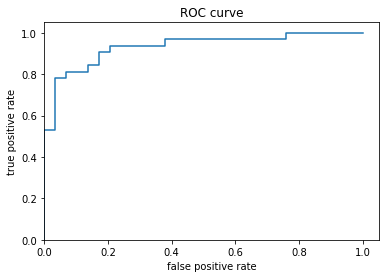

In [17]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(test_y, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);

## Feature Importants
- first will try and improve the Boosted Trees model

In [18]:
params = {
  'n_trees': 500,
  'max_depth': 1,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
pd.Series(results).to_frame()

W0319 02:23:57.533682 139783169553792 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpb5ong71n
W0319 02:23:58.219571 139783169553792 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0319 02:23:58.658732 139783169553792 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0319 02:23:58.772364 139783169553792 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0319 02:23:59.748302 139

,0
accuracy,0.836066
accuracy_baseline,0.524590
auc,0.915948
auc_precision_recall,0.916144
average_loss,0.383401
label/mean,0.524590
loss,0.383401
precision,0.866667
prediction/mean,0.451524
recall,0.812500


- got a bit better acc of .83 in this model and .82 in the old model (still not as good as the logitic model)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [20]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

### Directional Feature Contributions (DFCs) 
- this is only to look at what factors effected a spesific person

In [21]:
# Create DFC Pandas dataframe.
labels = test_y.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
ca,61.0,-0.016597,0.148400,-0.218746,-0.156649,0.097588,0.135117,0.149686
cp,61.0,-0.013398,0.106410,-0.139328,-0.110956,-0.081154,0.102754,0.125030
thal,61.0,-0.023651,0.114397,-0.153270,-0.129363,-0.101927,0.096646,0.110708
exang,61.0,-0.005141,0.059898,-0.103447,-0.073878,0.031627,0.044064,0.049050
slope,61.0,-0.005713,0.054478,-0.078277,-0.052419,-0.023755,0.050739,0.077725
oldpeak,61.0,-0.021558,0.137624,-0.442309,0.018008,0.036949,0.059139,0.069835
sex,61.0,-0.011228,0.038339,-0.047861,-0.038112,-0.020002,-0.012022,0.093166
chol,61.0,-0.003017,0.022003,-0.035857,-0.021772,-0.009914,0.016121,0.033449
thalach,61.0,0.001993,0.036795,-0.070304,-0.010165,-0.005962,-0.003571,0.144711
age,61.0,0.000344,0.003804,-0.006496,-0.002475,0.001026,0.003517,0.006001


In [22]:
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

In [23]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)
    
def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(test_set.iloc[ID][sorted_ix], ax)
  return ax

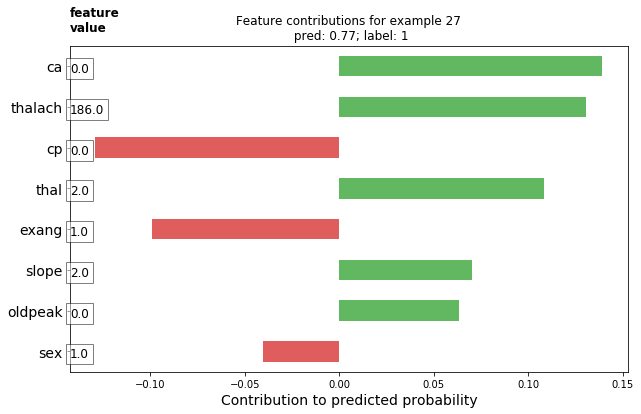

In [24]:
# Plot results.
ID = 27
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14);

### Gain-based feature importances

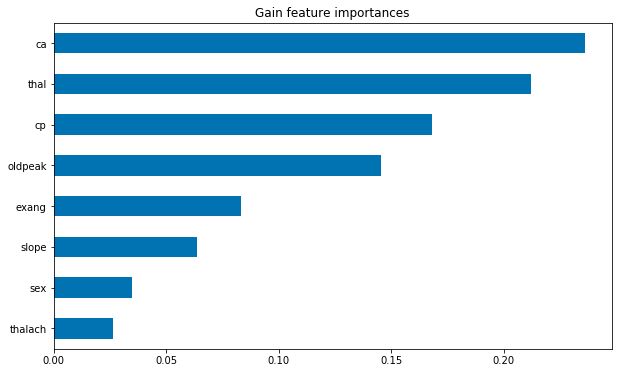

In [25]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

### Avrage DFC Over all Data

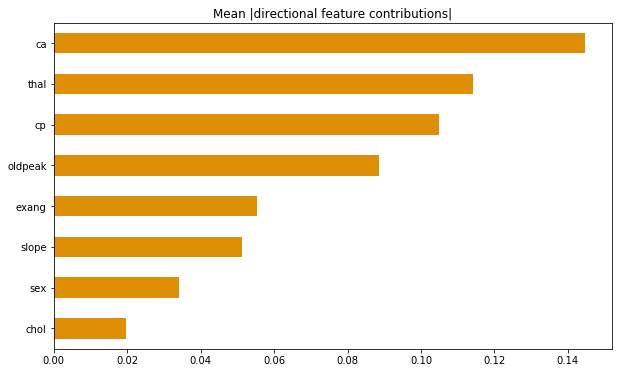

In [26]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

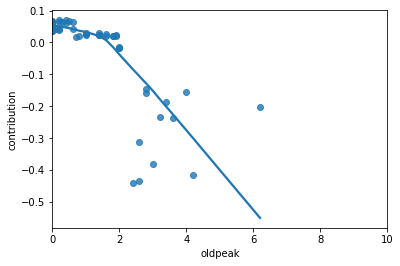

In [27]:
# see how much a feature contributes based on its value
FEATURE = 'oldpeak'
feature = pd.Series(df_dfc[FEATURE].values, index=test_set[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True);
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE);
ax.set_xlim(0, 10);

### Permutation feature importance
- in this part I was able to use the logistic model from earlier so I did

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


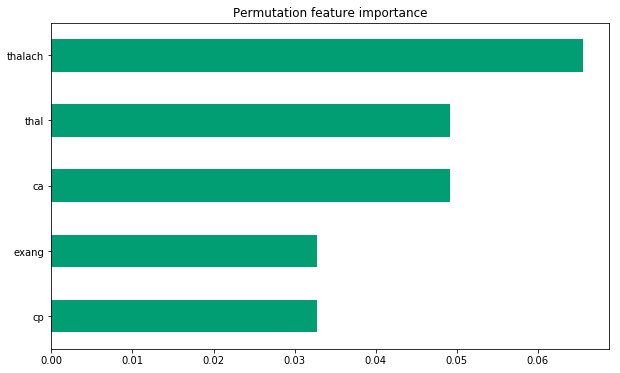

In [28]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.
    
    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(linear_est, test_set, test_y, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance');

for more about feature importants info check out this [blog post](https://explained.ai/rf-importance/index.html). also for more info about how the code works check out the tensorflow [website](https://www.tensorflow.org/alpha/tutorials/estimators/boosted_trees)